In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('train.csv')

train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8000 non-null   int64  
 1   category               8000 non-null   object 
 2   clicks                 7727 non-null   float64
 3   likes                  7624 non-null   float64
 4   buys                   8000 non-null   int64  
 5   4xx_errors             8000 non-null   int64  
 6   5xx_errors             8000 non-null   int64  
 7   complaints_count       7527 non-null   object 
 8   average_dwelltime      8000 non-null   float64
 9   source_attractiveness  8000 non-null   float64
 10  date_of_registration   8000 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 687.6+ KB


,Unnamed: 0,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness
count,8000.000000,7.727000e+03,7.624000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8000.000000
mean,5006.138875,2.749785e+06,5.985027e+05,5.810509e+05,8.204958e+04,2.769224e+04,6.979549,0.191997
std,2893.886162,4.699120e+06,1.978345e+06,2.262221e+06,1.555219e+05,7.946935e+04,10.004924,0.227873
min,0.000000,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-0.681718
25%,2493.250000,3.599210e+05,0.000000e+00,0.000000e+00,2.943000e+03,0.000000e+00,1.503928,0.038220
50%,5035.000000,1.097221e+06,3.399550e+04,0.000000e+00,2.671750e+04,0.000000e+00,4.022802,0.154256
75%,7521.250000,2.915358e+06,2.860638e+05,0.000000e+00,9.500225e+04,2.016375e+04,8.899400,0.282510
max,9999.000000,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,211.218066,1.355736


Преобразование категориального столбца в числовой формат

In [2]:
train_data = pd.get_dummies(train_data, columns=['category'], drop_first=True)


Преобразование даты в числовой формат

In [3]:
train_data['date_of_registration'] = pd.to_datetime(train_data['date_of_registration'])
train_data['days_since_registration'] = (train_data['date_of_registration'] - train_data['date_of_registration'].min()).dt.days

Обработка пропущенный значений

In [4]:
train_data.fillna(train_data.mean(), inplace=True)

C:\Users\dimas\AppData\Local\Temp\ipykernel_58000\2623544006.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train_data.fillna(train_data.mean(), inplace=True)
C:\Users\dimas\AppData\Local\Temp\ipykernel_58000\2623544006.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_data.fillna(train_data.mean(), inplace=True)


Разделение данных на признаки и целевую переменную

In [5]:
X = train_data.drop(columns=['source_attractiveness', 'date_of_registration'])
y = train_data['source_attractiveness']

избавление от `-`, `NaN`, пропусков

In [6]:
X.replace('-', pd.NA, inplace=True)

X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.mean(), inplace=True) 

масштабирование данных

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Инициализация и обучение модели

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_scaled, y)

LinearRegression()

Прогнозирование на тренировочных данных и оценка качества

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_scaled)

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R²: {r2}')

Mean Squared Error: 0.016161701033803547
Mean Absolute Error: 0.08796980990356057
R²: 0.6887180256825731


кросс-валидация

In [10]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
print(f'Mean CV Score: {-cv_scores.mean()}')

Mean CV Score: 0.08815166766749505


функция предсказания

In [11]:
def predict(path):
    test_data = pd.read_csv(path)
    test_data.replace('-', np.nan, inplace=True)
    test_data.fillna(test_data.median(), inplace=True)
    
    test_data = pd.get_dummies(test_data, columns=['category'], drop_first=True)
    test_data.drop(columns=[col for col in test_data.columns if 'Unnamed' in col], inplace=True)

    X_train_columns = X.columns
    for col in X_train_columns:
        if col not in test_data.columns:
            test_data[col] = 0 

    test_data = test_data[X_train_columns]

    X_test_scaled = scaler.transform(test_data)

    y_test_pred = model.predict(X_test_scaled)

    
    test_data['predicted_attractiveness'] = y_test_pred
    test_data[['predicted_attractiveness']].to_csv('predictions.csv', index=False)


predict('test.csv')

C:\Users\dimas\AppData\Local\Temp\ipykernel_58000\2125303862.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_data.fillna(test_data.median(), inplace=True)


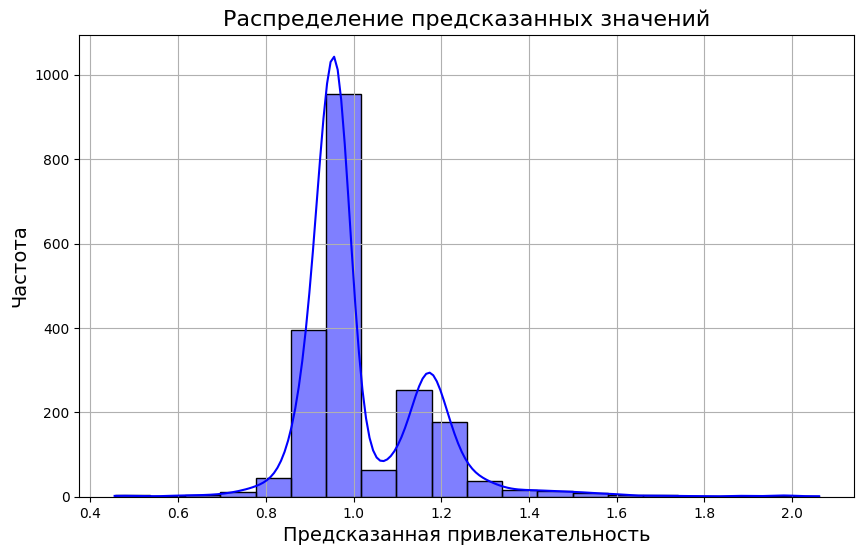

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns
predictions_data = pd.read_csv('predictions.csv')
# Построим распределение предсказанных значений
plt.figure(figsize=(10, 6))
sns.histplot(predictions_data['predicted_attractiveness'], kde=True, bins=20, color='blue')
plt.title('Распределение предсказанных значений', fontsize=16)
plt.xlabel('Предсказанная привлекательность', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(True)
plt.show()

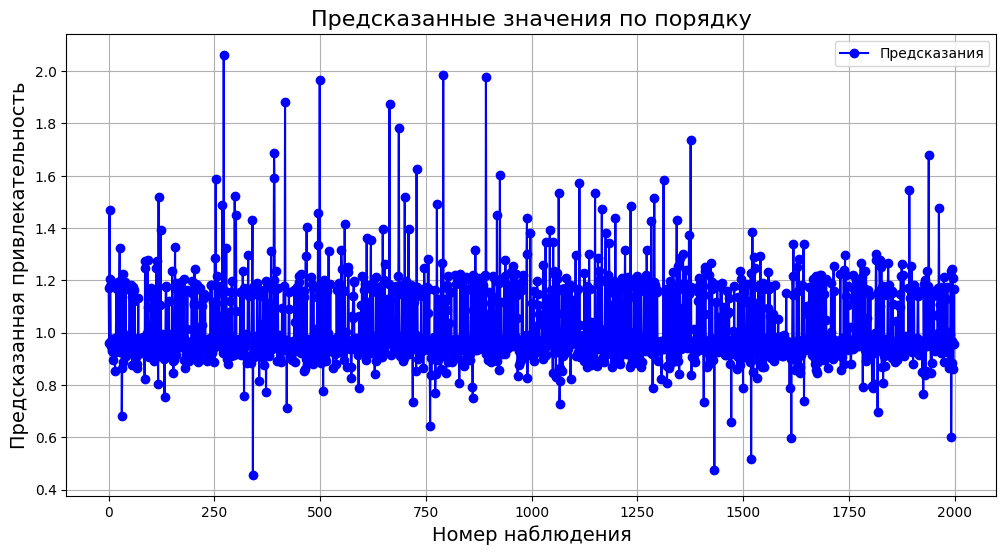

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(predictions_data['predicted_attractiveness'], marker='o', linestyle='-', color='blue', label='Предсказания')
plt.title('Предсказанные значения по порядку', fontsize=16)
plt.xlabel('Номер наблюдения', fontsize=14)
plt.ylabel('Предсказанная привлекательность', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()